In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from sklearn.metrics import r2_score
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from sklearn import preprocessing

In [87]:
column_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 
    'LSTAT', 'MEDV'
]

boston_data = pd.read_csv('housing.csv', 
                          header=None, 
                          delimiter=r"\s+", 
                          names=column_names)

In [88]:
d = preprocessing.normalize(boston_data)
scaled_boston_data = pd.DataFrame(d, columns=column_names)
scaled_boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.000013,0.035955,0.004614,0.0,0.001075,0.013134,0.130238,0.008170,0.001998,0.591265,0.030562,0.792814,0.009948,0.047940
1,0.000058,0.000000,0.014961,0.0,0.000992,0.013588,0.166966,0.010511,0.004232,0.512112,0.037668,0.839907,0.019342,0.045709
2,0.000058,0.000000,0.015133,0.0,0.001004,0.015379,0.130778,0.010632,0.004281,0.517974,0.038099,0.840809,0.008626,0.074272
3,0.000071,0.000000,0.004772,0.0,0.001003,0.015319,0.100257,0.013270,0.006567,0.485964,0.040935,0.863856,0.006436,0.073114
4,0.000150,0.000000,0.004740,0.0,0.000996,0.015539,0.117842,0.013181,0.006523,0.482675,0.040658,0.862945,0.011589,0.078707


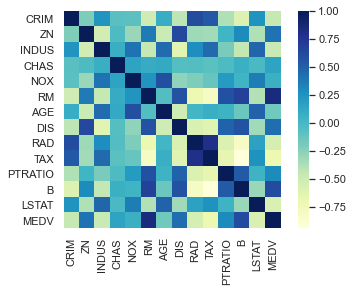

In [89]:
# Nakon normalizacije podatka, iscrtacu grafik na kome je prikazana korelacija izmedju podataka iz razlicitih kolona. Kao sto se vidi, 
# podaci obojeni belom bojom koreliraju najmanje, dok oni obojeni tamno plavo najvise koreliraju. Korelacija elemenata na dijagonali je jednaka 1,
# sto je logicno, obzirom da se radi o elementima iz iste kolone.
correlations = scaled_boston_data.corr()
sns.heatmap(correlations, square=True, cmap="YlGnBu")

plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

array([[<AxesSubplot:title={'center':'CRIM'}>,
        <AxesSubplot:title={'center':'ZN'}>,
        <AxesSubplot:title={'center':'INDUS'}>,
        <AxesSubplot:title={'center':'CHAS'}>],
       [<AxesSubplot:title={'center':'NOX'}>,
        <AxesSubplot:title={'center':'RM'}>,
        <AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'DIS'}>],
       [<AxesSubplot:title={'center':'RAD'}>,
        <AxesSubplot:title={'center':'TAX'}>,
        <AxesSubplot:title={'center':'PTRATIO'}>,
        <AxesSubplot:title={'center':'B'}>],
       [<AxesSubplot:title={'center':'LSTAT'}>,
        <AxesSubplot:title={'center':'MEDV'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

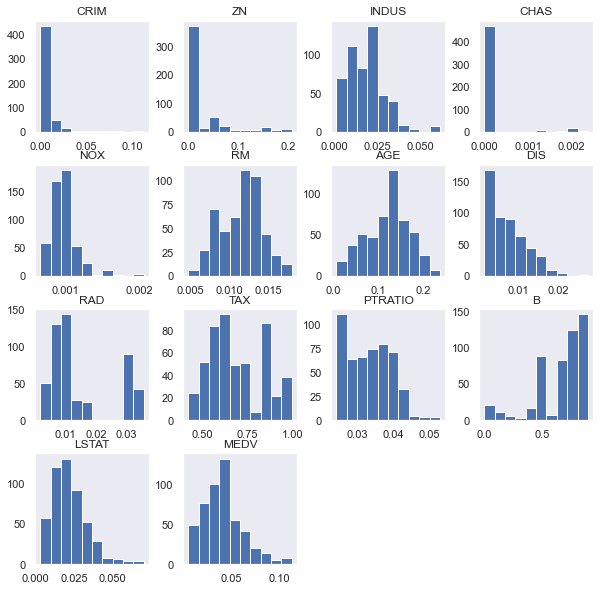

In [90]:
# Takodje, nacrtacu histograme svih kolona  pojedinacno i tu mogu da primetim da kolone Age i Medv imaju raspodelu koja je najpribliznija 
# normalnoj raspodeli. Recimo, kolona Dis ima eksponencijalnu raspodelu. Kod ostalih kolona, nije bas najvidiljivije koja raspodela je u pitanju.
scaled_boston_data.hist(bins=10, figsize=(10,10), grid=False)

In [91]:
#Biram kolonu Medv i delim u train i test set na klasican nacin. 

x = np.array(scaled_boston_data.drop(['MEDV'], axis=1))
y = scaled_boston_data['MEDV'].values

In [92]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)

In [93]:
# Definisem hiperparametre, pa pravim model. Definisem ulazni, skriveni i izlazni sloj.
batch_size = 50
num_epochs = 250
learning_rate = 0.001
hidden_size = 64
batch_no = len(x_train) // batch_size
input_dim = x.shape[1]

In [94]:
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1)
)

In [95]:
# Formiram loss funkciju (koristim Mean Square Error kao loss funkciju) i optimizer (Adam).
# Prosledila sam dva argumenta “model.parameters()” i “lr=0.005”. 
# Prvi su parametri modela neuronske mreže. Optimizator ažurira ove parametre u svakom ciklusu obuke.
# Drugi parametar je brzina učenja. Brzina učenja je parametar koji pokazuje koliko se parametri modela ažuriraju odjednom.
# U suštini, postepeno ažuriranje parametara će sigurno dovesti do optimalnog rešenja. 
# S druge strane, potrebno je vreme da se nauči. Zato je bitno razmisliti o stopi učenja i pronaći odgovarajuću vrednost.
# Koristila sam Adam optimizator u ovom slucaju.

loss = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
# Tek sada mogu da treniram model. U svakoj epohi se ispisuje loss i R2.

running_loss = 0

for epoch in range(num_epochs):
    for i in range(200):
        start = i
        end = start + 1
        
        x_batch = autograd.Variable(torch.FloatTensor(x_train[start:end]))
        y_batch = autograd.Variable(torch.FloatTensor(y_train[start:end]))
                
        y_pred = model(x_batch)
        
        loss_step = loss(y_pred, torch.unsqueeze(y_batch, dim=1))
        optimizer.zero_grad()
        loss_step.backward()
        optimizer.step()
        running_loss += loss_step.item()
    
    print("Epoch {}, Loss: {}. Validation R2: {}".format(
        epoch + 1, running_loss, r2_score(model(torch.Tensor(x_test)).detach().numpy(), y_test)))
    running_loss = 0.0

Epoch 1, Loss: 0.06312664801205303. Validation R2: -0.761912966381963
Epoch 2, Loss: 0.04596552652806182. Validation R2: -0.3828241679237727
Epoch 3, Loss: 0.04353500774686214. Validation R2: -0.2985625788607915
Epoch 4, Loss: 0.04161740850369622. Validation R2: -0.5927119936214824
Epoch 5, Loss: 0.04025204345532374. Validation R2: -0.620967520529621
Epoch 6, Loss: 0.039134151716795365. Validation R2: -0.6733253095345644
Epoch 7, Loss: 0.03856330747613468. Validation R2: -0.6633806204854407
Epoch 8, Loss: 0.03720308322745325. Validation R2: -0.6622984839015023
Epoch 9, Loss: 0.036113722458029685. Validation R2: -0.7238634221753126
Epoch 10, Loss: 0.03492077212421775. Validation R2: -0.6617238962030485
Epoch 11, Loss: 0.033689162629305436. Validation R2: -0.6033041399382013
Epoch 12, Loss: 0.03287784958056644. Validation R2: -0.6135129167463536
Epoch 13, Loss: 0.03175917706766129. Validation R2: -0.5779463991488931
Epoch 14, Loss: 0.030796478856337794. Validation R2: -0.5242715644957596